# CNN 實作 Tuberculosis X-ray 影像辨識 PyTorch

原本為貓狗影像辨識範例，改為深圳肺结核胸透数据集, 蒙哥马利肺结核数据集,Jaypee University 肺结核数据集來實驗。

## Reference

- https://medium.com/jimmyfu87/cnn%E5%AF%A6%E4%BD%9Ckaggle%E8%B2%93%E7%8B%97%E5%BD%B1%E5%83%8F%E8%BE%A8%E8%AD%98-pytorch-26380b357a3d

- https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte

- 【PyTorch】「CUDA error: device-side assert triggered」 解決の手引き : https://yuiga.dev/blog/posts/pytorchcuda_error_device-side_assert_triggered_%E8%A7%A3%E6%B1%BA%E3%81%AE%E6%89%8B%E5%BC%95%E3%81%8D/

- numpy 和 tensor 互相转换 : https://blog.csdn.net/AugustMe/article/details/113841470

- CUDA_LAUNCH_BLOCKING=1 : https://blog.csdn.net/weixin_43301333/article/details/121155260

- https://en.wikipedia.org/wiki/Tuberculosis

- https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

## Data

- 深圳肺结核胸透数据集 : https://aistudio.baidu.com/aistudio/datasetdetail/25237

- Montgomery County X-ray Set : https://aistudio.baidu.com/aistudio/datasetdetail/34229

- Chest X-rays tuberculosis from India (Tuberculosis dataset coming from Jaypee University of Information Technology (India).): https://www.kaggle.com/datasets/raddar/chest-xrays-tuberculosis-from-india



# Library

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models, transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from PIL import Image

# 準備資料、設定超參數

Path_train填入自己的資料夾路徑，Tuberculosis X-ray 裡面有 cim-normal, cim-tuberculosis 的資料夾，並設定 Batch 和 Learning Rate。

transforms 函數可以將圖片轉成(224,224)的像素，同時將圖片轉成 PyTorch 能讀取的 tensor 格式。

In [2]:
# PATH_train = "...../train"
# ./data/train
PATH_train = "./data/train"
TRAIN = Path(PATH_train)
# Batch：每批丟入多少張圖片
batch_size = 8
# Learning Rate：學習率
LR = 0.0001
transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])


## 指令

```
tree -f -L 3
```

## 目錄

```
(cd-init) kan@kan-MS-7E07:~/new-test/cd-test/tuberculosis-cnn-test$ tree -f -L 3
.
├── ./data
│   └── ./data/train
│       ├── ./data/train/cim-normal
│       └── ./data/train/cim-tuberculosis
├── ./env.sh
├── ./README.md
├── ./requirements.txt
├── ./save
└── ./tuberculosis.ipynb

5 directories, 4 files
(cd-init) kan@kan-MS-7E07:~/new-test/cd-test/tuberculosis-cnn-test$ 
```

# 切分訓練驗證集

用 ImageFolder 讀取檔案並套入前面 transforms 的轉換函數， ImageFolder 會把圖片根據資料夾給予 label，可以用 class_to_idx 查詢貓和狗分別對應的 label，print出來的結果會像這樣。

> 注意 ImageFolder 必須在資料夾內有子資料夾才可使用。

In [3]:
train_data = datasets.ImageFolder(TRAIN, transform=transforms)
# print(train_data.class_to_idx)
print(train_data.class_to_idx)
# 切分 70% 當作訓練集、30% 當作驗證集
train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])
# Dataloader 可以用 Batch 的方式訓練
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,shuffle=True)

{'cim-normal': 0, 'cim-tuberculosis': 1}


# 建立CNN的架構

這邊要定義自己的 CNN 架構，我用最簡單的範例，基本上 CNN 最主要就是 Convolutional 和 Maxpool 兩種層所組成，Relu 是激發函數，然後最後要用線性層輸出預測結果。

EX : 貓狗是兩個種類，所以 Linear 後面的參數就是 2，輸出結果如[0.487,0.9527]，index為 1 的狗比較大，代表預測結果為狗。

> {'cim-normal': 0, 'cim-tuberculosis': 1}

最後也可以加一層 Softmax 讓兩者機率加起來為 1 如[0.7,0.3])

PyTorch 最少要定義兩個 function，一個是 __init__，用來建立你 forward 需要用到哪些層，另一個是 forward，也就是定義路徑要怎麼走，不需另外定義 Backward，PyTorch 會自動幫你設定 Back-propagation 的路徑。

## 參數的設定

- self.cnn1=nn.Conv2d(3,16,kernal_size=5,stride=1)

3 代表input的channel，因為圖片是RGB所以是3，16代表output的channel，這邊我用了16個hidden node所以為16，kernel_size是5*5的filter。

- self.maxpool1 = nn.MaxPool2d(kernel_size=2)

這裡的kernel_size代表2*2的格子取最大的一格，會將8*8縮成4*4。

- self.fc = nn.Linear(8 * 50 * 50, 2)

至於線性層為何是(8*50*50,2)，根據下面這個公式算出下一層的shape，如原圖是(3,224,224)經過cnn1後，(224–5+1)/(1+1)=110，因此maxpool1的input就變成(16,110,110)，而Maxpool1的kernal_size為2，因此output就變成(16,55,55)，以此類推最後的Shape就變成(8*50*50,2)。

> (weight-kernel+1)/stride+1 無條件進位
 

In [4]:
class CNN_Model(nn.Module):
    # 列出需要哪些層
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(3, 16, kernel_size=5, stride=1) 
        self.relu1 = nn.ReLU(inplace=True) 
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(16,8, kernel_size=11, stride=1) 
        self.relu2 = nn.ReLU(inplace=True) 
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Fully connected 1 ,#input_shape=(8*50*50)
        self.fc = nn.Linear(8 * 50 * 50, 2)     
    # 列出 forward 的路徑，將 init 列出的層代入
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out) 
        return out

# 定義訓練過程、計算 Loss、Accuracy

這邊先將訓練、驗證模組化，傳入的函數包含model(要使用的模型)、n_epochs(迭代次數)、train_loader、valid_loader(訓練、驗證集)、optimizer(優化器)、Criterion(損失函數)。

1. train_loss和valid loss 是算出每個 batch 的平均 loss
2. tqdm 可以很好的跟data製作出進度條(如上圖)
3. model.eval() 會關閉 batchnorm 、 dropout ，雖這範例沒有，但一般都會用到
4. output.data.max 用來輸出較大的 index 如[0.487,0.9527]，則輸出1 P
5. Validation 階段不需做 BP，所以少了幾步

In [5]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu = False
print('Pytorch CUDA:', torch.cuda.is_available())
print('Train GPU:', train_on_gpu)
def train(model, n_epochs, train_loader, valid_loader, optimizer, criterion):
    train_acc_his,valid_acc_his=[],[]
    train_losses_his,valid_losses_his=[],[]
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss,valid_loss = 0.0,0.0
        train_losses,valid_losses=[],[]
        train_correct,val_correct,train_total,val_total=0,0,0,0
        train_pred,train_target=torch.zeros(8,1),torch.zeros(8,1)
        val_pred,val_target=torch.zeros(8,1),torch.zeros(8,1)
        count=0
        count2=0
        print('running epoch: {}'.format(epoch))
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in tqdm(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # test target
            # TypeError: cross_entropy_loss(): argument 'target' (position 2) must be Tensor, not builtin_function_or_method
            # ex:torch.from_numpy(x)
            # target = torch.Tensor(target)
            # calculate the batch loss
            loss = criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_losses.append(loss.item()*data.size(0))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if count==0:
                train_pred=pred
                train_target=target.data.view_as(pred)
                count=count+1
            else:
                train_pred=torch.cat((train_pred,pred), 0)
                train_target=torch.cat((train_target,target.data.view_as(pred)), 0)
        train_pred=train_pred.cpu().view(-1).numpy().tolist()
        train_target=train_target.cpu().view(-1).numpy().tolist()
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            print(model(data))
            # calculate the batch loss
            loss =criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            val_total += data.size(0)
            valid_losses.append(loss.item()*data.size(0))
            if count2==0:
                val_pred=pred
                val_target=target.data.view_as(pred)
                count2=count+1
            else:
                val_pred=torch.cat((val_pred,pred), 0)
                val_target=torch.cat((val_target,target.data.view_as(pred)), 0)
        val_pred=val_pred.cpu().view(-1).numpy().tolist()
        val_target=val_target.cpu().view(-1).numpy().tolist()
        
        # calculate average losses
        train_loss=np.average(train_losses)
        valid_loss=np.average(valid_losses)
        
        # calculate average accuracy
        train_acc=train_correct/train_total
        valid_acc=val_correct/val_total
        train_acc_his.append(train_acc)
        valid_acc_his.append(valid_acc)
        train_losses_his.append(train_loss)
        valid_losses_his.append(valid_loss)
        # print training/validation statistics 
        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            train_loss, valid_loss))
        print('\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            train_acc, valid_acc))
    return train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model

Pytorch CUDA: True
Train GPU: False


# 開始訓練
首先初始化 CNN_Model()，使用最常用的 Adam 作為 Optimizer，由於是分類問題 Loss Function 選用 CrossEntropy，代入函數即可以開始訓練。

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
torch.cuda.device_count()

1

In [7]:
model1 = CNN_Model()
# if torch.cuda.is_available():
#     model1.cuda()
model1.cpu()
n_epochs = 10
optimizer1 = torch.optim.Adam(model1.parameters(), lr=LR)
# criterion = CrossEntropyLoss()
criterion = CrossEntropyLoss()
# cross_entropy_loss(models, target_tensor)
train_acc_his,valid_acc_his,train_losses_his, valid_losses_his, model1 = train(model1, n_epochs, train_loader, valid_loader, optimizer1, criterion)

running epoch: 1


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[-0.0249,  0.0005],
        [-0.0340,  0.0036],
        [-0.0214, -0.0059],
        [-0.0304,  0.0051],
        [-0.0258,  0.0041],
        [-0.0243,  0.0023],
        [-0.0297,  0.0128],
        [-0.0323,  0.0039]], grad_fn=<AddmmBackward0>)
tensor([[-0.0365,  0.0137],
        [-0.0236, -0.0050],
        [-0.0300,  0.0133],
        [-0.0326,  0.0059],
        [-0.0226, -0.0034],
        [-0.0309, -0.0037],
        [-0.0230, -0.0083],
        [-0.0368,  0.0073]], grad_fn=<AddmmBackward0>)
tensor([[-0.0339,  0.0055],
        [-0.0306, -0.0002],
        [-0.0274, -0.0031],
        [-0.0273, -0.0013],
        [-0.0257,  0.0141],
        [-0.0270,  0.0017],
        [-0.0277,  0.0037],
        [-0.0351,  0.0023]], grad_fn=<AddmmBackward0>)
tensor([[-0.0278,  0.0018],
        [-0.0401,  0.0076],
        [-0.0320,  0.0059],
        [-0.0268,  0.0018],
        [-0.0263,  0.0050],
        [-0.0251,  0.0037],
        [-0.0271,  0.0042],
        [-0.0340,  0.0191]], grad_fn=<AddmmBackward

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[-0.0241,  0.0243],
        [ 0.0345, -0.0369],
        [ 0.0141,  0.0018],
        [-0.0145, -0.0003],
        [-0.0080,  0.0134],
        [-0.0299,  0.0324],
        [ 0.0024, -0.0085],
        [-0.0290,  0.0236]], grad_fn=<AddmmBackward0>)
tensor([[-0.0183,  0.0147],
        [-0.0363,  0.0274],
        [-0.0069, -0.0130],
        [-0.0478,  0.0486],
        [ 0.0466, -0.0448],
        [-0.0073, -0.0087],
        [-0.0446,  0.0390],
        [-0.0209,  0.0241]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0249, -0.0180],
        [-0.0375,  0.0306],
        [-0.0243,  0.0132],
        [-0.0226,  0.0230],
        [ 0.0116, -0.0049],
        [ 0.0279, -0.0273],
        [ 0.0297, -0.0223],
        [-0.0006,  0.0055]], grad_fn=<AddmmBackward0>)
tensor([[-0.0137,  0.0241],
        [-0.0227,  0.0341],
        [-0.0178,  0.0248],
        [ 0.0375, -0.0200],
        [-0.0116,  0.0073],
        [ 0.0025,  0.0049],
        [-0.0232,  0.0354],
        [-0.0049,  0.0024]], grad_fn=<AddmmBackward

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[ 0.0059, -0.0810],
        [ 0.0550, -0.1481],
        [ 0.1979, -0.2615],
        [ 0.1446, -0.1923],
        [ 0.1840, -0.2371],
        [ 0.0854, -0.1103],
        [ 0.0337, -0.0947],
        [-0.0713, -0.0182]], grad_fn=<AddmmBackward0>)
tensor([[ 0.2149, -0.2591],
        [ 0.0995, -0.1743],
        [ 0.0644, -0.1238],
        [-0.0039, -0.0595],
        [ 0.0711, -0.1378],
        [ 0.0394, -0.0769],
        [ 0.0203, -0.0763],
        [ 0.1572, -0.2183]], grad_fn=<AddmmBackward0>)
tensor([[ 0.1327, -0.1816],
        [ 0.1168, -0.1776],
        [ 0.0455, -0.1222],
        [ 0.1859, -0.2353],
        [ 0.0703, -0.1233],
        [ 0.1407, -0.2091],
        [ 0.1018, -0.1777],
        [ 0.1620, -0.2221]], grad_fn=<AddmmBackward0>)
tensor([[-0.0499, -0.0290],
        [ 0.1928, -0.2384],
        [ 0.0646, -0.1306],
        [ 0.1245, -0.1663],
        [ 0.1317, -0.1434],
        [ 0.1528, -0.2062],
        [ 0.0430, -0.0900],
        [-0.0108, -0.0757]], grad_fn=<AddmmBackward

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[ 0.1387, -0.1883],
        [-0.1338,  0.0303],
        [-0.0452, -0.0862],
        [-0.2035,  0.0213],
        [-1.0391,  0.8726],
        [-1.3806,  1.3126],
        [-0.5261,  0.4116],
        [-0.1890,  0.0672]], grad_fn=<AddmmBackward0>)
tensor([[-0.1819,  0.0859],
        [ 0.1555, -0.2873],
        [-1.2170,  1.1391],
        [-0.5621,  0.4548],
        [-0.1970,  0.0916],
        [-0.7501,  0.6158],
        [-0.1926, -0.0301],
        [-0.7569,  0.6398]], grad_fn=<AddmmBackward0>)
tensor([[-0.6190,  0.4217],
        [-0.1087,  0.0404],
        [-0.0794,  0.0046],
        [-0.4716,  0.3455],
        [-0.1732,  0.1408],
        [-0.2085,  0.1373],
        [ 0.0681, -0.0074],
        [-1.1549,  1.0686]], grad_fn=<AddmmBackward0>)
tensor([[-0.5165,  0.5144],
        [-0.2104,  0.1340],
        [-0.3128,  0.2953],
        [-0.4778,  0.3776],
        [ 0.0780,  0.0203],
        [-0.1905,  0.1544],
        [-0.9059,  0.8254],
        [-0.6089,  0.5471]], grad_fn=<AddmmBackward

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[-0.7249,  0.6336],
        [ 0.3894, -0.3937],
        [ 0.5344, -0.4573],
        [ 0.8274, -0.8303],
        [ 0.0928, -0.0864],
        [-0.5835,  0.5777],
        [-0.2539,  0.2393],
        [-0.4629,  0.4312]], grad_fn=<AddmmBackward0>)
tensor([[ 0.4868, -0.4885],
        [ 0.4060, -0.3357],
        [-0.5322,  0.4727],
        [-0.6139,  0.6164],
        [ 0.2792, -0.2381],
        [ 0.0579, -0.0481],
        [ 0.2372, -0.2811],
        [-0.1089,  0.0197]], grad_fn=<AddmmBackward0>)
tensor([[-0.1458,  0.0908],
        [ 0.6061, -0.6330],
        [-0.1566,  0.1316],
        [ 0.2379, -0.2342],
        [-1.1697,  1.1475],
        [ 0.0349, -0.0491],
        [ 0.3644, -0.3005],
        [-1.0024,  0.9837]], grad_fn=<AddmmBackward0>)
tensor([[-0.3869,  0.3603],
        [-0.6456,  0.6059],
        [-0.2359,  0.1878],
        [-0.1278,  0.0905],
        [ 0.4531, -0.5001],
        [-0.9562,  0.9331],
        [-0.9648,  0.9243],
        [-1.1485,  1.1652]], grad_fn=<AddmmBackward

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[ 1.0598, -1.1811],
        [-0.2128,  0.1174],
        [-0.3032,  0.1908],
        [-0.2504,  0.1559],
        [ 1.1027, -0.9739],
        [ 0.1701, -0.3258],
        [ 0.3998, -0.5192],
        [ 0.4080, -0.5793]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0353, -0.0739],
        [ 0.6099, -0.6865],
        [ 0.0349, -0.2021],
        [ 0.6778, -0.8668],
        [ 0.9462, -1.0390],
        [ 1.1842, -1.1229],
        [-0.3817,  0.2659],
        [ 0.9956, -1.1143]], grad_fn=<AddmmBackward0>)
tensor([[ 0.4406, -0.5094],
        [ 0.1124, -0.1915],
        [ 0.9688, -0.9000],
        [-0.5547,  0.4735],
        [-0.2726,  0.2366],
        [ 1.2180, -1.2577],
        [ 0.6848, -0.7431],
        [-0.3129,  0.1888]], grad_fn=<AddmmBackward0>)
tensor([[-0.0264,  0.0169],
        [-0.5474,  0.4760],
        [ 0.9880, -0.9957],
        [-0.5739,  0.4383],
        [ 1.0691, -1.0438],
        [ 0.1481, -0.1667],
        [-0.6367,  0.4880],
        [-0.7380,  0.6344]], grad_fn=<AddmmBackward

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[-1.6179,  1.5545],
        [ 0.1242, -0.2957],
        [ 0.1951, -0.2483],
        [ 0.3691, -0.5627],
        [-0.3853,  0.2256],
        [-0.5024,  0.3437],
        [ 0.3887, -0.5076],
        [ 0.0338, -0.0789]], grad_fn=<AddmmBackward0>)
tensor([[-0.0341, -0.1025],
        [-0.2422,  0.1067],
        [ 0.3493, -0.5281],
        [-0.2892,  0.0310],
        [-1.0597,  0.9500],
        [-0.7037,  0.4458],
        [-0.1385,  0.1034],
        [ 0.5932, -0.7626]], grad_fn=<AddmmBackward0>)
tensor([[-0.6268,  0.3552],
        [ 0.2038, -0.2750],
        [-1.1225,  1.1779],
        [-0.1263, -0.0861],
        [-0.3994,  0.4032],
        [-1.0711,  0.9477],
        [ 0.3260, -0.4483],
        [-0.7337,  0.7920]], grad_fn=<AddmmBackward0>)
tensor([[ 0.6399, -0.6636],
        [-0.3305,  0.1850],
        [ 0.2567, -0.3732],
        [-0.3358,  0.0531],
        [-1.3294,  1.1655],
        [-1.2350,  1.1111],
        [-1.0740,  0.8872],
        [-1.4304,  1.3050]], grad_fn=<AddmmBackward

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[-0.3214,  0.1804],
        [ 0.2403, -0.4005],
        [-0.8884,  0.7995],
        [ 0.0261, -0.2794],
        [-1.0499,  0.9739],
        [-0.2160,  0.0590],
        [ 0.3119, -0.5666],
        [-0.1087,  0.0590]], grad_fn=<AddmmBackward0>)
tensor([[ 1.9979e-01, -3.6805e-01],
        [ 6.7575e-02, -8.8474e-02],
        [ 9.7567e-01, -1.0149e+00],
        [-2.2106e-01,  5.3135e-04],
        [ 5.4027e-01, -8.0823e-01],
        [ 1.2378e+00, -1.4155e+00],
        [-1.5012e-01,  2.3041e-01],
        [-5.7895e-01,  3.2385e-01]], grad_fn=<AddmmBackward0>)
tensor([[-0.1575,  0.0878],
        [ 0.6449, -0.8516],
        [ 0.0023, -0.1876],
        [ 0.4810, -0.6742],
        [ 0.7649, -1.0005],
        [-0.8540,  0.7485],
        [ 0.9289, -1.0343],
        [ 0.2786, -0.3987]], grad_fn=<AddmmBackward0>)
tensor([[ 1.0345, -1.1015],
        [ 0.8326, -0.9082],
        [ 0.0488, -0.1194],
        [-0.3421,  0.1698],
        [ 0.3773, -0.5704],
        [-0.3617,  0.1386],
        [ 0.332

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[ 0.2044, -0.3746],
        [ 0.9922, -1.1391],
        [-0.2346,  0.1230],
        [-0.4921,  0.3983],
        [ 0.3942, -0.4470],
        [ 0.1217, -0.1902],
        [-0.7283,  0.6468],
        [ 0.2988, -0.4248]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5291, -0.6702],
        [ 0.7236, -0.7675],
        [-0.0793, -0.0114],
        [ 0.3699, -0.4713],
        [ 0.3797, -0.5634],
        [ 1.0985, -1.0800],
        [ 0.8007, -0.7414],
        [ 0.1064, -0.2220]], grad_fn=<AddmmBackward0>)
tensor([[ 0.9345, -0.9996],
        [-0.1014,  0.0595],
        [-0.1769,  0.2999],
        [ 1.1221, -1.0733],
        [-0.4526,  0.5939],
        [ 1.0555, -1.1899],
        [-0.5283,  0.5423],
        [ 0.3804, -0.4015]], grad_fn=<AddmmBackward0>)
tensor([[ 0.8430, -0.9062],
        [-0.1903,  0.1449],
        [-0.6635,  0.5161],
        [-0.2289,  0.1530],
        [ 0.6368, -0.7184],
        [-0.3429,  0.3204],
        [-0.3042,  0.1471],
        [-0.2912,  0.1815]], grad_fn=<AddmmBackward

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

tensor([[ 0.5005, -0.6387],
        [ 0.3603, -0.4384],
        [ 0.0107, -0.2692],
        [ 1.2028, -1.1911],
        [ 0.5853, -0.6505],
        [-0.8923,  0.8203],
        [ 0.7056, -0.8967],
        [-0.5896,  0.5415]], grad_fn=<AddmmBackward0>)
tensor([[ 1.2284, -1.2991],
        [ 1.7063, -1.5638],
        [ 0.9604, -1.0124],
        [ 0.7293, -0.7575],
        [ 0.8461, -0.9436],
        [ 1.3358, -1.3844],
        [ 1.8330, -1.9480],
        [-0.6317,  0.4632]], grad_fn=<AddmmBackward0>)
tensor([[ 1.1710, -1.1508],
        [-0.6271,  0.6038],
        [ 0.0173, -0.2377],
        [ 0.3406, -0.2956],
        [ 0.4163, -0.4051],
        [-0.2442,  0.1786],
        [ 0.3112, -0.3503],
        [ 1.3689, -1.4717]], grad_fn=<AddmmBackward0>)
tensor([[ 0.3917, -0.5569],
        [ 0.1571, -0.2917],
        [ 1.4172, -1.4915],
        [ 0.9609, -0.9041],
        [ 1.4706, -1.5968],
        [ 1.3138, -1.3762],
        [-1.2012,  1.1125],
        [ 0.7934, -0.9832]], grad_fn=<AddmmBackward

# 訓練結果、儲存 Model

這邊就可以把剛剛訓練完的結果留下來，並畫成 loss 和 accuracy 圖，檢驗訓練的狀況，由於訓練非常耗時間，可以用 torch.save 的函數把訓練好的 model 保存下來，之後就可以直接 load 進來用。

> 做範例示範，所以用了很簡單的架構及非常少的 data，所以從上面的圖可發現 training 和 validation 差非常遠，有非常嚴重的 Overfitting 的問題，因此之後可以再去進行調整。

原範例用貓狗各 100 張，在此用肺结核数据集數據集進行訓練。

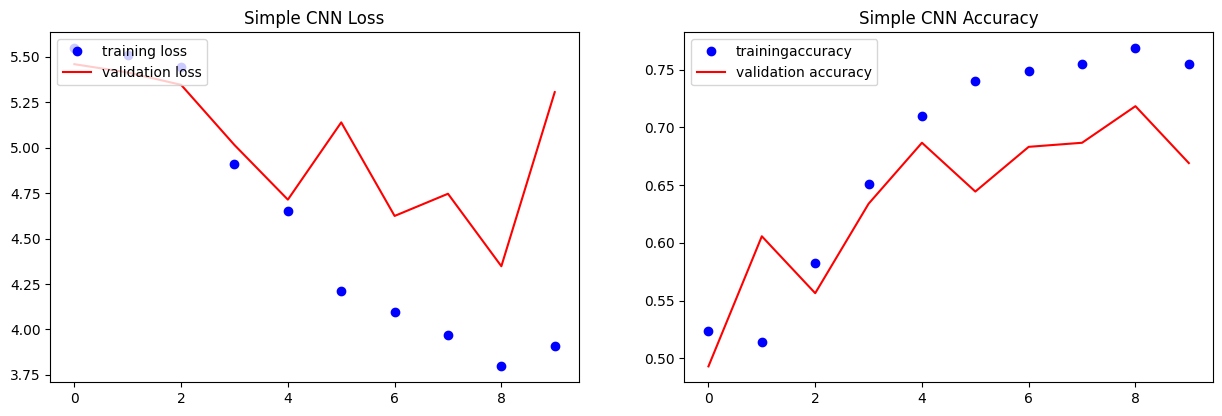

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'trainingaccuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN Accuracy")
plt.legend(loc='upper left')
plt.show()
torch.save(model1, "save/model")
# model1 = torch.load('save/model')